## Spatial Data Analysis using Python and OpenData

Python Pizza Hamburg, December 11th, 2021

Prof. Martin Christen<br/>
mailto:martin.christen@fhnw.ch<br/>
Twitter: @MartinChristen<br/>
LinkedIn: https://www.linkedin.com/in/martinchristen/

### GitHub

This notebook will be available at: https://github.com/martinchristen/pythonpizzahamburg2021

## 1. Installation of required Modules

(This tutorial requires anaconda, if you don't have it yet, download it here: https://www.anaconda.com/download/ ).

If you try without anaconda: good luck!

**This notebook requires Python 3.7**

Some Geo-Modules are still not ported to 3.8+ on all platforms. With 3.7 we're safe on all major operating Systems.<br/> 
(If you have a Mac with M1 processor you still need a little bit patience)

### Installing Modules (conda)

Install the main modules using conda, dependencies will be resolved (gdal etc.)

    
    conda create --name PizzaHamburg python=3.7 jupyterlab -y
    conda activate PizzaHamburg
    conda install matplotlib -y
    conda install shapely -y
    conda install fiona -y
    conda install rasterio -y
    conda install geopandas -y
    conda install descartes -y
    conda install folium -c conda-forge -y
    conda install h3-py -c conda-forge -y 

### 1. Introduction to Shapely

https://shapely.readthedocs.io/en/stable/manual.html

![Features](img/Features.png)

Shapely supports the following Features:

* Point
* LineString
* LinearRing          
* Polygon
* MultiLineString
* MultiPoint
* MultiPolygon

Let's construct a Hexagon. (with or without H3)

In [34]:
import math

radius = 10
coords = []
for i in range(0,6):
    angle = i*60*math.pi/180
    coords.append((radius * math.cos(angle), radius*math.sin(angle)))
coords

[(10.0, 0.0),
 (5.000000000000001, 8.660254037844386),
 (-4.999999999999998, 8.660254037844387),
 (-10.0, 1.2246467991473533e-15),
 (-5.000000000000004, -8.660254037844386),
 (5.000000000000001, -8.660254037844386)]

Definition for Polygons: first and last point must be same

So let's add it

In [35]:
# First and last point must be same in polygon
coords.append(coords[0])

In [36]:
coords

[(10.0, 0.0),
 (5.000000000000001, 8.660254037844386),
 (-4.999999999999998, 8.660254037844387),
 (-10.0, 1.2246467991473533e-15),
 (-5.000000000000004, -8.660254037844386),
 (5.000000000000001, -8.660254037844386),
 (10.0, 0.0)]

In [37]:
from shapely.geometry import Polygon

In [38]:
hexagon = Polygon(coords)

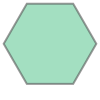

In [39]:
hexagon

In [40]:
hexagon.length

60.00000000000001

In [41]:
hexagon.area

259.80762113533154

Let's create another Polygon, this time a triangle

In [42]:
triangle = Polygon([(-5,0),(0,6),(5,0),(-5,0)])

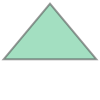

In [43]:
triangle  # note: this output is scaled

We can plot the exerior using matplotlib:

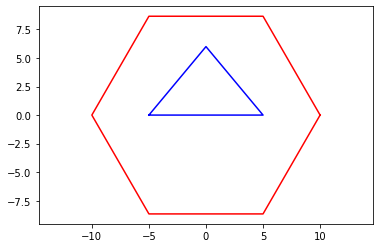

In [44]:
import matplotlib.pyplot as plt

x1,y1 = hexagon.exterior.xy
x2,y2 = triangle.exterior.xy
plt.plot(x1,y1, 'r')
plt.plot(x2,y2, 'b')
plt.axis("equal");

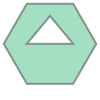

In [45]:
hexagon.difference(triangle)

We can do:
   * intersection
   * union
   * difference
   * symmetric_difference

Let's move the triangle a bit to the right to test this

In [46]:
triangle = Polygon([(5,0),(10,6),(15,0),(5,0)])

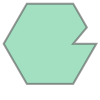

In [47]:
hexagon.difference(triangle)

In [ ]:
#intersection
hexagon.intersection(triangle)

In [ ]:
hexagon.union(triangle)

In [ ]:
hexagon.symmetric_difference(triangle)

wkt: Well Known Text - simple way to display 
    
more info: https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry

In [ ]:
hexagon.symmetric_difference(triangle).wkt

### Binary operations on shapes:

- **contains** (Returns True if the interior of the object intersects the interior of the other but does not contain it, and the dimension of the intersection is less than the dimension of the one or the other.)
- **intersects** (Returns True if the boundary and interior of the object intersect in any way with those of the other.)
- **witin** (Returns True if the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).
- **touches** (Returns True if the objects have at least one point in common and their interiors do not intersect with any part of the other.)
- **crosses** (Returns True if the interior of the object intersects the interior of the other but does not contain it, and the dimension of the intersection is less than the dimension of the one or the other.)
- **equals** (Returns True if the set-theoretic boundary, interior, and exterior of the object coincide with those of the other.)

In [ ]:
triangle.intersects(hexagon)

### Draw a Polygon (GeoJSON) on Map


Geographic Coordinates

![Coords](img/longitude.gif)

In [ ]:
from shapely.geometry import mapping

geojson = mapping(hexagon)

geojson

In [ ]:
import folium

map_ch = folium.Map(location=[0, 0], zoom_start=7)  
folium.GeoJson(geojson).add_to(map_ch)
map_ch

If you want hexagons all around the world, use h3

<img width="30%" src="http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/image12.png" />

In [ ]:
import h3
from shapely.geometry import Polygon, mapping

h3Index = h3.geo_to_h3(0,0, 3);
coords = h3.h3_set_to_multi_polygon([h3Index])
coords = coords[0][0]
coords.append(coords[0])
hexagon = Polygon(coords)
hexagon

## 2. GeoPandas

Let's use the open data set of geonames.org - all cities with population > 5000.

In [ ]:
import pandas as pd

df = pd.read_csv('data/cities5k.csv', encoding="utf-8", sep=",", header=None, low_memory=False)
df.head(3)

### Removing Columns for Demo...

We really have too many columns, to make everything easier, I just reduce to the most important ones and give some column names.
This is all standard pandas...

In [ ]:
df2 = df[[1,4,5,7,14]]
df2.columns = ["name", "lat", "lng", "type", "population"]
df2.head()

In [ ]:
df2.query("name == 'Paris'")

Remove sections, see https://www.geonames.org/export/codes.html for more details

In [ ]:
df2 = df2[df2.type != 'PPLX']
df2.head()

### Creating a GeoPandas Data Frame

We simply need a **geometry** column containing a **shaply geometry**

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(pos) for pos in zip(df2['lng'], df2['lat'])]
gdf = gpd.GeoDataFrame(df2, geometry=geometry)

gdf.head()

We can remove the columns "lat" and "lng", it is redundant. 

In [ ]:
gdf = gdf.drop(['lat', 'lng'], axis=1)

In [ ]:
%matplotlib inline
gdf.plot(color='green', markersize=15, figsize=(15,9));

In [ ]:
from shapely.geometry import Point

Basel = Point([7.59348379, 47.570333604])

dist = gdf.distance(Basel)

In [ ]:
gdf_new = gdf.copy()
gdf_new["distance"] = dist

In [ ]:
gdf_new

In [ ]:
s = gdf_new.sort_values(["distance"], ascending=True)
s.head(10)

In [ ]:
big_cities = gdf_new[gdf_new.population > 5000000]
big_cities.head()

### Now display cities on a folium map using markers

In [ ]:
import folium

map_cities = folium.Map(location=[47.570333604, 7.59348379], zoom_start=2)

def create_marker(row):
    lng = row["geometry"].x
    lat = row["geometry"].y
    name = row["name"]
    population = str(int(row["population"]))
    folium.Marker([lat, lng], popup=f'{name}, population:{population}').add_to(map_cities)
    
big_cities.apply(create_marker, axis=1)
map_cities


### 3. Live Data & GeoPandas

We're looking at the earthquake data from USGS:
https://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

This data is updated every minute

In [1]:
import requests

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
#url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/significant_month.geojson"
#url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.geojson"

data = requests.get(url)
file = open("earthquakes.geojson","wb")
file.write(data.content)
file.close()

In [2]:
import geopandas as gpd

eq_gdf = gpd.read_file("earthquakes.geojson")
eq_gdf.head()

,id,mag,place,time,updated,tz,url,detail,felt,cdi,...,sources,types,nst,dmin,rms,gap,magType,type,title,geometry
0,tx2021yfnt,3.5,"56 km S of Whites City, New Mexico",1639229332092,1639231030374,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,NaN,NaN,...,",us,tx,",",origin,phase-data,",43.0,0.085953,0.20,69.0,ml,earthquake,"M 3.5 - 56 km S of Whites City, New Mexico",POINT Z (-104.36549 31.66577 7.26272)
1,us6000gbes,2.6,"6 km WSW of Gypsum, Kansas",1639221510864,1639224209040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,NaN,NaN,...,",us,",",origin,phase-data,",NaN,0.735000,0.51,144.0,mb_lg,earthquake,"M 2.6 - 6 km WSW of Gypsum, Kansas",POINT Z (-97.49780 38.68390 5.00000)
2,ak021fuqjmgx,2.7,"27 km WNW of Four Mile Road, Alaska",1639218659751,1639221345040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,NaN,NaN,...,",us,ak,",",origin,phase-data,",NaN,NaN,0.67,NaN,ml,earthquake,"M 2.7 - 27 km WNW of Four Mile Road, Alaska",POINT Z (-149.61200 64.72730 14.50000)
3,tx2021yfhw,2.9,"56 km S of Whites City, New Mexico",1639218642177,1639220305040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,NaN,NaN,...,",us,tx,",",origin,phase-data,",35.0,0.088089,0.20,58.0,ml,earthquake,"M 2.9 - 56 km S of Whites City, New Mexico",POINT Z (-104.36822 31.67035 6.85139)
4,us6000gbej,3.0,"5 km WSW of Gypsum, Kansas",1639218500150,1639226197162,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/earthquakes/feed/v...,5.0,4.1,...,",us,",",dyfi,origin,phase-data,",NaN,0.746000,0.24,145.0,mb_lg,earthquake,"M 3.0 - 5 km WSW of Gypsum, Kansas",POINT Z (-97.49330 38.69480 2.68000)


Let's simplify the output and only take most important rows

In [3]:
eq = eq_gdf[["time","mag", "place","geometry"]].copy()
eq.head()

,time,mag,place,geometry
0,1639229332092,3.5,"56 km S of Whites City, New Mexico",POINT Z (-104.36549 31.66577 7.26272)
1,1639221510864,2.6,"6 km WSW of Gypsum, Kansas",POINT Z (-97.49780 38.68390 5.00000)
2,1639218659751,2.7,"27 km WNW of Four Mile Road, Alaska",POINT Z (-149.61200 64.72730 14.50000)
3,1639218642177,2.9,"56 km S of Whites City, New Mexico",POINT Z (-104.36822 31.67035 6.85139)
4,1639218500150,3.0,"5 km WSW of Gypsum, Kansas",POINT Z (-97.49330 38.69480 2.68000)


Look at the histogramm:

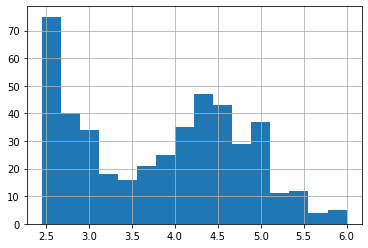

In [4]:
eq.mag.hist(bins=16);

Timestamps in UTC are not really human readable...
Let's convert them

In [5]:
from datetime import datetime, timezone

data = []
for row in range(0,len(eq)):
    time = eq.iloc[row].time
    t = str(datetime.fromtimestamp(time/1000.0, timezone.utc))
    data.append(t)
    
eq["time_utc"] = data
eq.head()

,time,mag,place,geometry,time_utc
0,1639229332092,3.5,"56 km S of Whites City, New Mexico",POINT Z (-104.36549 31.66577 7.26272),2021-12-11 13:28:52.092000+00:00
1,1639221510864,2.6,"6 km WSW of Gypsum, Kansas",POINT Z (-97.49780 38.68390 5.00000),2021-12-11 11:18:30.864000+00:00
2,1639218659751,2.7,"27 km WNW of Four Mile Road, Alaska",POINT Z (-149.61200 64.72730 14.50000),2021-12-11 10:30:59.751000+00:00
3,1639218642177,2.9,"56 km S of Whites City, New Mexico",POINT Z (-104.36822 31.67035 6.85139),2021-12-11 10:30:42.177000+00:00
4,1639218500150,3.0,"5 km WSW of Gypsum, Kansas",POINT Z (-97.49330 38.69480 2.68000),2021-12-11 10:28:20.150000+00:00


In [6]:
eq = eq.drop(['time'], axis=1)

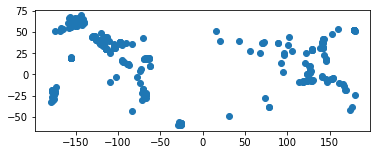

In [7]:
eq.plot();

Open Natural Earth Dataset with all Polygons of all countries

In [8]:
gdfAdmin0 = gpd.read_file("data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", encoding="utf-8")
gdfAdmin0.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,칠레,Chili,Chile,Chile,Чили,Chile,Şili,Chile,智利,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,볼리비아,Bolivia,Boliwia,Bolívia,Боливия,Bolivia,Bolivya,Bolivia,玻利維亞,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,페루,Peru,Peru,Peru,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


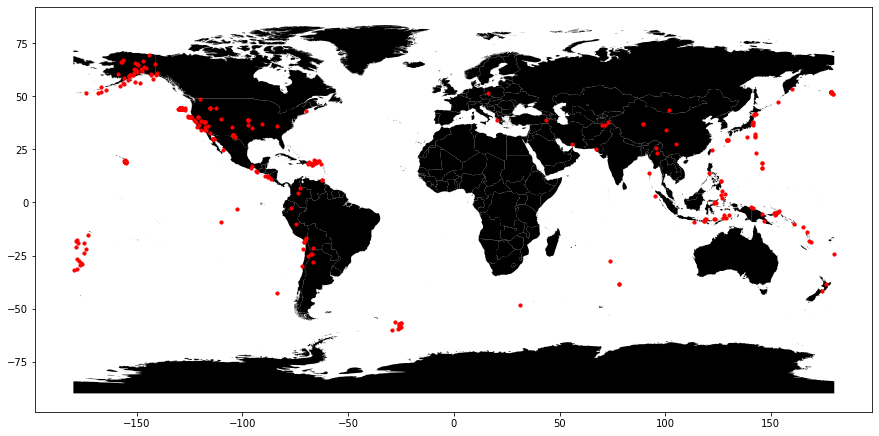

In [9]:
countries = gdfAdmin0.plot(figsize=(15,9), color="black")
eq.plot(ax=countries, color="red", markersize=10);

In [10]:
eq.sort_values(["mag"], ascending=False).head()

,mag,place,geometry,time_utc
437,6.0,"259 km N of Tobelo, Indonesia",POINT Z (128.13590 4.06810 174.26000),2021-12-04 23:47:57.708000+00:00
144,6.0,"119 km N of Naze, Japan",POINT Z (129.37910 29.44280 7.00000),2021-12-09 02:05:07.709000+00:00
288,5.8,South Sandwich Islands region,POINT Z (-25.82450 -57.50540 33.40000),2021-12-07 15:55:54.241000+00:00
266,5.8,off the coast of Oregon,POINT Z (-129.53190 44.40120 10.00000),2021-12-08 00:36:38.804000+00:00
263,5.8,off the coast of Oregon,POINT Z (-128.96720 44.43690 10.00000),2021-12-08 01:21:05.668000+00:00


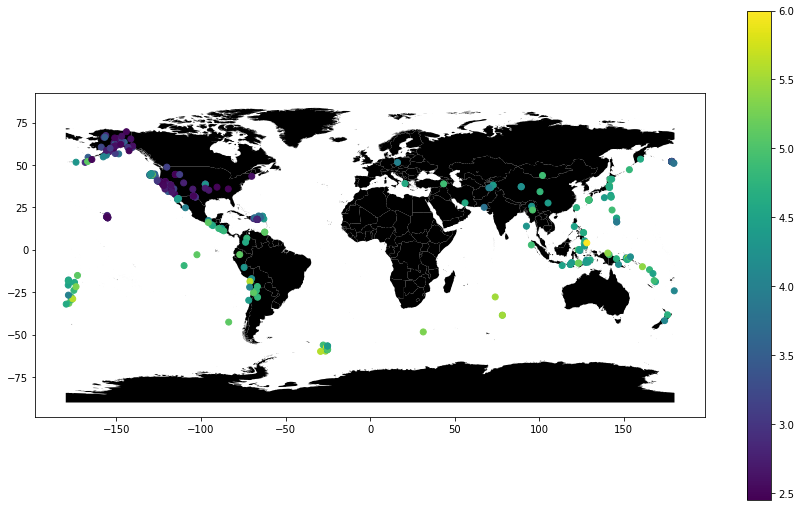

In [56]:
countries = gdfAdmin0.plot(figsize=(15,9), color="black")
eq.plot(ax=countries,column='mag', legend=True);

### 4. More GeoPandas Fun

In [28]:
import geopandas as gpd

gdfAdmin0 = gpd.read_file("data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", encoding="utf-8")
gdfAdmin0.head()


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
92,Admin-0 country,0,4,Switzerland,CHE,0,2,Sovereign country,Switzerland,CHE,...,스위스,Zwitserland,Szwajcaria,Suíça,Швейцария,Schweiz,İsviçre,Thụy Sĩ,瑞士,"POLYGON ((10.45381 46.86443, 10.44854 46.83223..."


<AxesSubplot:>

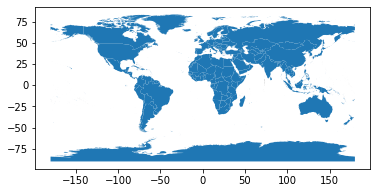

In [70]:
gdfAdmin0.plot()

#### Spatial join

Do a spatial join with Earthquakes using the operation "contains".

This will return polygons of countries with earthquakes


In [78]:
df_result = gpd.sjoin(gdfAdmin0, eq, op='contains')
df_result.drop_duplicates(subset=['ADMIN']) # removes duplicate countries

df_result.head()


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,index_right,mag,place,time_utc
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",363,4.4,"18 km SSW of Dompu, Indonesia",2021-12-06 04:03:31.166000+00:00
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,Чили,Chile,Şili,Chile,智利,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",375,5.1,Chile-Argentina border region,2021-12-05 21:51:09.623000+00:00
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,Боливия,Bolivia,Bolivya,Bolivia,玻利維亞,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",308,4.8,"89 km SSW of Atocha, Bolivia",2021-12-07 07:47:11.642000+00:00
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",35,4.6,southern Peru,2021-12-10 18:59:33.525000+00:00
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",53,4.2,"34 km N of Chuquitira, Peru",2021-12-10 09:09:12.560000+00:00


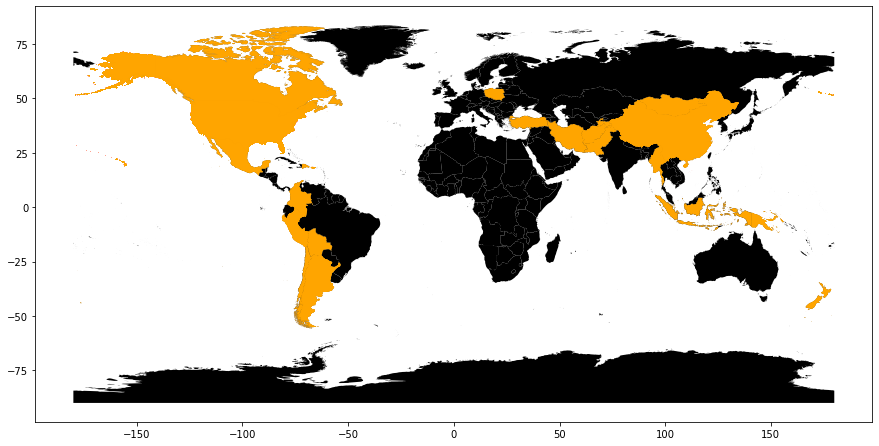

In [80]:
countries = gdfAdmin0.plot(figsize=(15,9), color="black")
df_result.plot(ax=countries, color="orange");

#### In which country did the earthquake occur ?




In [77]:
df_result = gpd.sjoin(eq, gdfAdmin0, op='intersects')
df_result = df_result[["time_utc", "mag", "NAME" ,"geometry"]] # just simplify for readability
df_result

,time_utc,mag,NAME,geometry
0,2021-12-11 13:28:52.092000+00:00,3.5,United States of America,POINT Z (-104.36549 31.66577 7.26272)
1,2021-12-11 11:18:30.864000+00:00,2.6,United States of America,POINT Z (-97.49780 38.68390 5.00000)
2,2021-12-11 10:30:59.751000+00:00,2.7,United States of America,POINT Z (-149.61200 64.72730 14.50000)
3,2021-12-11 10:30:42.177000+00:00,2.9,United States of America,POINT Z (-104.36822 31.67035 6.85139)
4,2021-12-11 10:28:20.150000+00:00,3.0,United States of America,POINT Z (-97.49330 38.69480 2.68000)
...,...,...,...,...
363,2021-12-06 04:03:31.166000+00:00,4.4,Indonesia,POINT Z (118.37570 -8.68020 10.00000)
375,2021-12-05 21:51:09.623000+00:00,5.1,Chile,POINT Z (-68.94400 -25.30990 97.15000)
376,2021-12-05 21:46:47.989000+00:00,4.9,Turkey,POINT Z (43.47520 38.85720 8.65000)
383,2021-12-05 17:42:14.239000+00:00,4.3,Afghanistan,POINT Z (71.37900 36.67450 178.05000)


Now something else: let's look at a single polygon

In [ ]:
ch = gdfAdmin0[gdfAdmin0['NAME'] == "Switzerland"]
ch

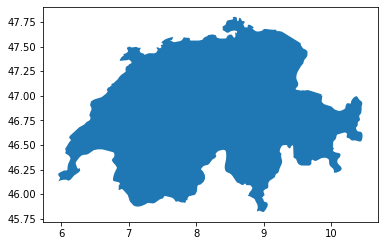

In [29]:
ch.plot();

In [62]:
ch.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [69]:
df_result

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,index_right,mag,place,time_utc
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",363,4.40,"18 km SSW of Dompu, Indonesia",2021-12-06 04:03:31.166000+00:00
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,Чили,Chile,Şili,Chile,智利,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",375,5.10,Chile-Argentina border region,2021-12-05 21:51:09.623000+00:00
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,Боливия,Bolivia,Bolivya,Bolivia,玻利維亞,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",308,4.80,"89 km SSW of Atocha, Bolivia",2021-12-07 07:47:11.642000+00:00
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",35,4.60,southern Peru,2021-12-10 18:59:33.525000+00:00
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,Перу,Peru,Peru,Peru,秘鲁,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",53,4.20,"34 km N of Chuquitira, Peru",2021-12-10 09:09:12.560000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Admin-0 country,6,5,United States of America,US1,1,2,Dependency,Puerto Rico,PRI,...,Пуэрто-Рико,Puerto Rico,Porto Riko,Puerto Rico,波多黎各,"MULTIPOLYGON (((-67.85587 18.11469, -67.84435 ...",70,4.19,"1 km W of Indios, Puerto Rico",2021-12-10 01:25:34.040000+00:00
207,Admin-0 country,6,5,United States of America,US1,1,2,Dependency,Puerto Rico,PRI,...,Пуэрто-Рико,Puerto Rico,Porto Riko,Puerto Rico,波多黎各,"MULTIPOLYGON (((-67.85587 18.11469, -67.84435 ...",52,2.74,"1 km WNW of Indios, Puerto Rico",2021-12-10 09:39:02.610000+00:00
207,Admin-0 country,6,5,United States of America,US1,1,2,Dependency,Puerto Rico,PRI,...,Пуэрто-Рико,Puerto Rico,Porto Riko,Puerto Rico,波多黎各,"MULTIPOLYGON (((-67.85587 18.11469, -67.84435 ...",63,2.62,"1 km WNW of Indios, Puerto Rico",2021-12-10 04:36:16.310000+00:00
207,Admin-0 country,6,5,United States of America,US1,1,2,Dependency,Puerto Rico,PRI,...,Пуэрто-Рико,Puerto Rico,Porto Riko,Puerto Rico,波多黎各,"MULTIPOLYGON (((-67.85587 18.11469, -67.84435 ...",13,2.60,"1 km S of Magas Arriba, Puerto Rico",2021-12-11 05:33:53.370000+00:00


In [30]:
import folium

center = [47.570333604, 7.59348379] 
map_ch = folium.Map(center, zoom_start=5)   

folium.GeoJson(ch).add_to(map_ch)

map_ch

In [31]:
from shapely.geometry import mapping

shapely_polygon = ch["geometry"].iloc(0)[0]
print(shapely_polygon.wkt[0:1500])

POLYGON ((10.45381107600014 46.86442738900006, 10.4485400800001 46.83223297100001, 10.44492273000012 46.82324127200006, 10.43903161600011 46.81688507100004, 10.41722416200008 46.79884999700003, 10.41908451300009 46.78396718300009, 10.42621586100003 46.76942026800005, 10.42869633000001 46.75564849900009, 10.41660404400011 46.74301361100008, 10.39965417500011 46.73554636700005, 10.39562341300012 46.72639963900006, 10.39655358800007 46.71500498400006, 10.39438317900007 46.70081980400001, 10.38477136300008 46.68901173900009, 10.37391931200011 46.68190623000008, 10.36916508000013 46.67239776600009, 10.3775366620001 46.65327748599999, 10.39562341300012 46.63880808500006, 10.4382047930001 46.63565582300002, 10.45908207200006 46.62356353800003, 10.46662683100001 46.60428822900009, 10.4659033610001 46.57847585100008, 10.45794519000015 46.55369700100003, 10.45183267900012 46.54670157200006, 10.44399255400015 46.53772898400008, 10.42590580300015 46.53532603000004, 10.35428226700009 46.54832265300

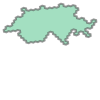

In [48]:
import h3

geojson = mapping(shapely_polygon)

hexes = h3.polyfill_geojson(geojson, 5)

coords = h3.h3_set_to_multi_polygon(hexes, geo_json=True)
coords = coords[0][0]
coords.append(coords[0])
hexagon = Polygon(coords)
hexagon


In [49]:
import folium

center = [47.570333604, 7.59348379] 
m = folium.Map(center, zoom_start=7)   

folium.GeoJson(hexagon).add_to(m)

m

### 5. Raster Data with rasterio



In [ ]:
import rasterio

dataset = rasterio.open('data/BlueMarble.tif', 'r')

In [ ]:
dataset.name

In [ ]:
dataset.count # number of raster bands, in our case 3 for r,g,b

In [ ]:
dataset.width, dataset.height

In [ ]:
dataset.crs

In [ ]:
dataset.bounds

In [ ]:
dataset.transform  # affine transformation pixel to crs

In [ ]:
dataset.transform * (0, 0)    # Pixel to CRS

In [ ]:
~dataset.transform # inverse affine transformation

In [ ]:
~dataset.transform * (0,0) # CRS to Pixel

In [ ]:
px, py = ~dataset.transform * (7.59348379, 47.570333604) # Our Location to Pixel (lng/lat)
print(px,py)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
r = dataset.read(1)
g = dataset.read(2)
b = dataset.read(3)

In [ ]:
rgb = np.dstack((r,g,b))  # stack r,g,b so we can display it...

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(rgb, interpolation='nearest')
ax.plot(px,py, 'ro'); 

## GeoPython 2022

Yes, there will be an GeoPython 2022. And yes, it will be in person/hybrid.<br/>
The number of in-person attendees may be limited, we will be ready in January with a decision.<br/>


<img src="img/FlyerGeoPython2022.png" />


<br/>

* Follow @GeoPythonConf on Twitter: http://twitter.com/GeoPythonConf
* The website will be available soon, probably January.
* Talk submission starts in January too.


